In [20]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import pickle
import numpy as np

import seaborn as sns
from datetime import time

#Import function to clean data, add time and date columns
from clean_mta import get_and_clean_frame

## Step 1 - Import all the data, pass it to the cleaning/processing function, then concatenate 4 weeks together into a single dataframe and delete the single week frames

In [13]:
aug24to31 = get_and_clean_frame('190831')

In [14]:
sept1to7 = get_and_clean_frame('190907')

In [21]:
sept7to14 = get_and_clean_frame('190914')

In [22]:
sept14to21 = get_and_clean_frame('190921')

In [ ]:
sept_data = pd.concat([aug24to31,sept1to7,sept7to14,sept14to21])
del aug24to31
del sept1to7
del sept7to14
del sept14to21
sept_data.info()

## Step 2 - Identify stations with highest total entries over the entire 4 week period, then save the top 8 stations with the highest traffic as a dataframe

In [71]:
sept_data.groupby('STATION').new_entries.sum().sort_values(ascending=False)
top_stations = pd.DataFrame(sept_data.groupby('STATION').new_entries.sum().sort_values(ascending=False).head(8)).reset_index()

## Step 3 - Generate a plot showing the stations with the highest traffic

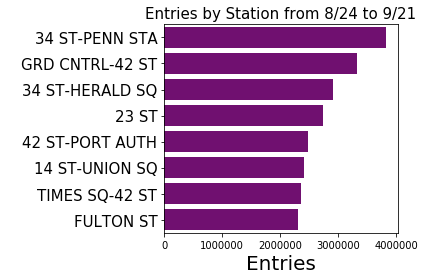

In [72]:
station_plot = sns.barplot(data=top_stations.reset_index(), y='STATION',x='new_entries', color='purple')
station_plot.set_yticklabels(tempplot.get_yticklabels(), fontsize=15)
plt.ylabel(" ",fontsize=10)
plt.title("Entries by Station from 8/24 to 9/21", fontsize=15)
plt.xlabel("Entries",fontsize=20)
plt.tight_layout()
plt.savefig("station-totals.png")

## Step 4 - Generate a day by day plot showing traffic over the course of a week for the top 5 stations

In [73]:
def dayCountsStation(df, stationList):
    #Make an empty dataframe to add day of week counts to for each station
    days = ['Saturday','Sunday','Monday','Tuesday','Wednesday','Thursday','Friday']
    day_frame = pd.DataFrame(index=days)

    #Add a column for each station that has total entries per day_of_week
    for station in stationList:
        df_filter = df[df['STATION']==station]
        day_frame[station]=df_filter.groupby(df_filter['day-of-week']).new_entries.sum()
    
    return day_frame

In [76]:
#Use function to create dataframe of day of week counts for top 5 stations
station_list= ['34 ST-PENN STA','GRD CNTRL-42 ST','34 ST-HERALD SQ',  '23 ST','42 ST-PORT AUTH']
by_day = dayCountsStation(sept_data, station_list)

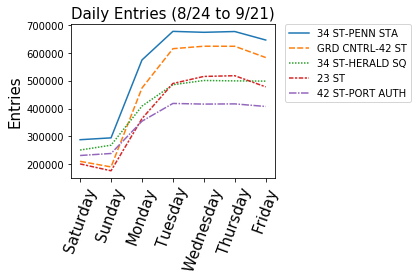

In [78]:
sns.lineplot(data=by_day, sort=False)
plt.xticks(fontsize=15, rotation=70)
plt.ylabel("Entries",fontsize=15)
plt.title("Daily Entries (8/24 to 9/21)", fontsize=15)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.savefig("dayofweek_totals.png")

## Step 5 - Generate a time series plot of entries by time of day at top stations

In [82]:
def generateTimeDf(date_df,station):
    #List of timeframes to bin datetime objects by - will become keys in dictionary
    binlist = ["Midnight to 4am","4am to 8am","8am to noon","noon to 4pm","4pm to 8pm","8pm to mid"]

    #Generate a list of masks to filter by time, lumping timeframes together
    #Example: include 4:00:00 in "Midnight to 4am"
    mask4 = (date_df['time'] >= time(0,0,1)) & (date_df['time'] <= time(4,0,0))
    mask8 = (date_df['time'] >= time(4,0,1)) & (date_df['time'] <= time(8,0,0))
    mask12 = (date_df['time'] >= time(8,0,1)) & (date_df['time'] <= time(12,0,0))
    mask16 = (date_df['time'] >= time(12,0,1)) & (date_df['time'] <= time(16,0,0))
    mask20 = (date_df['time'] >= time(16,0,1)) & (date_df['time'] <= time(20,0,0))
    mask24 = (
        ((date_df['time'] >= time(20,0,1)) & (date_df['time'] < time(23,59,59))) 
        | (date_df['time'] == time(0,0,0))
        )

    masklist = [mask4, mask8,mask12,mask16,mask20,mask24]

    #For each bin, use the appropriate mask and create a dictionary entry 
    #with the sum of the new_entries
    tempdict = {}
    for i in range(len(masklist)):
        tempdict[binlist[i]]=date_df[masklist[i]].new_entries.sum()
    
    return tempdict

In [84]:

#Create an empty dataframe to hold the dictionary output of the function
binlist = ["Midnight to 4am","4am to 8am","8am to noon","noon to 4pm","4pm to 8pm","8pm to mid"]
timebindf = pd.DataFrame(index=binlist)

#For each station in the top5, add the dictionary of entries by time of day to a new dataframe
for station in station_list:
    df_filter = sept_data[sept_data['STATION']==station]
    timebindf[station]=pd.Series(generateTimeDf(df_filter,station))

timebindf.astype('int32')

,34 ST-PENN STA,GRD CNTRL-42 ST,34 ST-HERALD SQ,23 ST,42 ST-PORT AUTH
Midnight to 4am,108835,131998,79298,124919,147747
4am to 8am,351739,133352,151732,66383,368484
8am to noon,1157776,564508,492636,369717,636101
noon to 4pm,680857,605390,606797,574294,386586
4pm to 8pm,1041302,1051609,1168911,1029883,571245
8pm to mid,489521,832755,412836,577337,373093


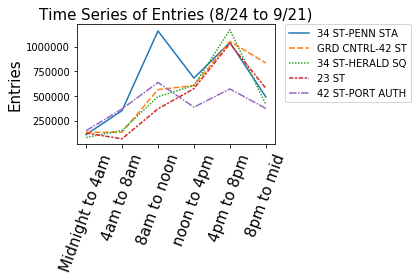

In [87]:
# Make the plot of the top 5 stations across times of day
sns.lineplot(data=timebindf,sort=False)
plt.xticks(fontsize=15, rotation=70)
plt.ylabel("Entries",fontsize=15)
plt.title("Time Series of Entries (8/24 to 9/21)", fontsize=15)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.savefig("timebin_totals.png")